In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import sklearn.metrics as metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import svm

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.9 MB/s 


In [ ]:
import shap

In [ ]:
shap.__version__

'0.41.0'

In [ ]:
def train_test_val_prep(X, y, test_size = 0.3, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, 
    stratify = y, random_state = random_state)
    X_val, X_test, y_val, y_test = train_test_split(
                X_test, y_test, test_size = 0.5, 
                stratify = y_test, random_state = random_state)
    #print('train:val:test - ', '{:.3f}'.format(sum(y_train)/len(y_train)), '{:.3f}'.format(sum(y_val)/len(y_val)), 
         # '{:.3f}'.format(sum(y_test)/len(y_test)))
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def make_shap_waterfall_plot(shap_values, features, num_display=20, title = ''):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    if title != '':
      plt.title(title)
    # Shap waterfall plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Set1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set1.csv', index_col=0)
#Set2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set2.csv', index_col=0)
#Set3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set3.csv', index_col=0)
Set4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set4.csv', index_col=0)
Set5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set5.csv', index_col=0)
Set6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set6.csv', index_col=0)
Set7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set7.csv', index_col=0)
Set8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set8.csv', index_col=0)
Set9 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Chembl4495582_Fomina/Chembl4495582_Set9.csv', index_col=0)

In [ ]:
RF_model_Set4 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 2, min_samples_split = 3)
RF_model_Set5 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15)
RF_model_Set6 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15)
RF_model_Set7 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 5, min_samples_split = 15)
RF_model_Set8 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15)
RF_model_Set9 = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 1000, random_state=42, 
                                  criterion = 'gini', max_depth=7, min_samples_leaf = 7, min_samples_split = 15)

In [ ]:
Set4

,Chembl_Name,0,1,2,3,4,5,6,7,8,...,7vh8_B VAL 212,Grid_Score_7jkv,Grid_Score_7cb7,Grid_Score_7mpb,Grid_Score_7mhp,Grid_Score_7vh8,Grid_Score_7rc0,Mw,logP,Experiment_label
0,CHEMBL10,0,0,0,0,0,0,0,0,0,...,0.0,-34.610703,-37.316181,-30.805252,-31.948048,-36.003437,-27.870602,377.440,3.138292,0
1,CHEMBL100,0,0,0,1,1,0,0,0,0,...,0.0,-32.077488,-34.852295,-31.238728,-27.943371,-35.349831,-33.367020,286.331,1.022024,0
2,CHEMBL100259,0,0,0,0,0,0,0,0,0,...,0.0,-33.875603,-34.560555,-34.023727,-30.177105,-35.462032,-33.423267,244.203,-2.415242,0
3,CHEMBL100424,0,0,0,0,1,0,0,0,0,...,0.0,-29.238535,-30.326897,-31.173742,-28.237204,-30.232658,-31.082962,238.370,2.263478,0
4,CHEMBL100473,0,1,0,0,0,1,0,0,0,...,0.0,-36.352177,-36.932201,-42.139709,-41.349922,-39.431709,-38.675064,380.490,1.953302,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,CHEMBL995,0,0,0,0,0,0,0,0,0,...,0.0,-46.512009,-45.560795,-40.692627,-45.211800,-43.341118,-44.733994,421.910,5.003479,0
6728,CHEMBL996,0,0,0,0,0,1,1,0,0,...,0.0,-48.202133,-41.931141,-46.609779,-43.989006,-48.202469,-47.242767,427.450,0.288359,0
6729,CHEMBL99668,0,0,0,0,0,0,0,0,0,...,0.0,-36.934975,-38.844261,-35.831299,-35.069622,-36.915371,-35.920124,291.267,-1.422364,0
6730,CHEMBL9967,0,0,0,0,0,0,0,0,0,...,0.0,-43.421879,-46.475452,-42.751408,-36.070297,-44.013496,-41.348061,351.410,0.967023,0


### Set2

In [ ]:
dataset = Set2
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label'], axis = 1)
X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_2 = X_train_2.drop('Chembl_Name', axis=1)
X_val_clean_2 = X_val_2.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set2.fit(X_train_clean_2,y_train_2)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer2 = shap.TreeExplainer(RF_model_Set2)
shap_values2 = explainer2.shap_values(X_train_clean_2, approximate=False, check_additivity=False)

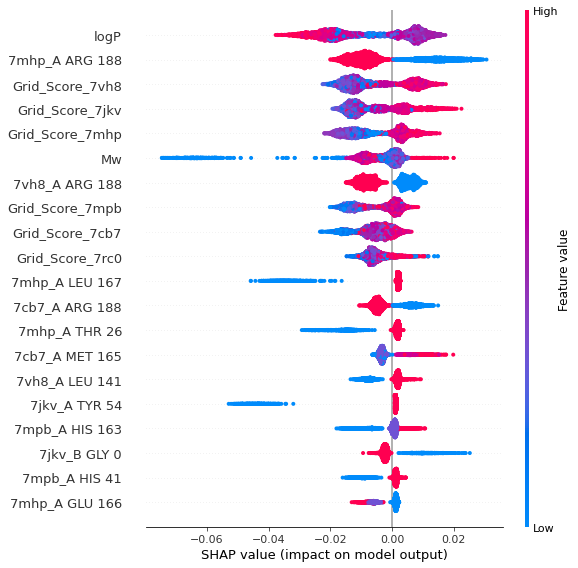

In [ ]:
shap.summary_plot(shap_values2[1], X_train_clean_2)

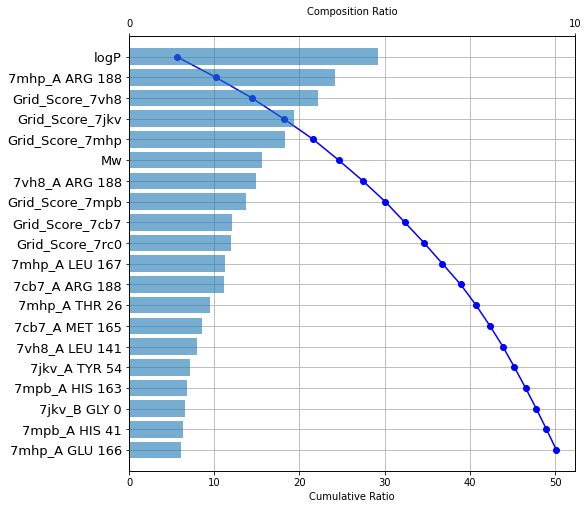

In [ ]:
make_shap_waterfall_plot(shap_values2[1], X_train_clean_2)

### Set4

In [ ]:
dataset = Set4
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_4, X_val_4, X_test_4, y_train_4, y_val_4, y_test_4 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)

In [ ]:
X_train_clean_4 = X_train_4.drop('Chembl_Name', axis=1)
X_val_clean_4 = X_val_4.drop('Chembl_Name', axis=1)
#scaler = MinMaxScaler()
#scaler.fit(X_train_clean_4)
#X_train_clean_4 = scaler.transform(X_train_clean_4)
#X_val_clean_4 = scaler.transform(X_val_clean_4)

In [ ]:
RF_model_Set4.fit(X_train_clean_4,y_train_4)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer4 = shap.TreeExplainer(RF_model_Set4)
shap_values4 = explainer4.shap_values(X_train_clean_4, approximate=False, check_additivity=False)

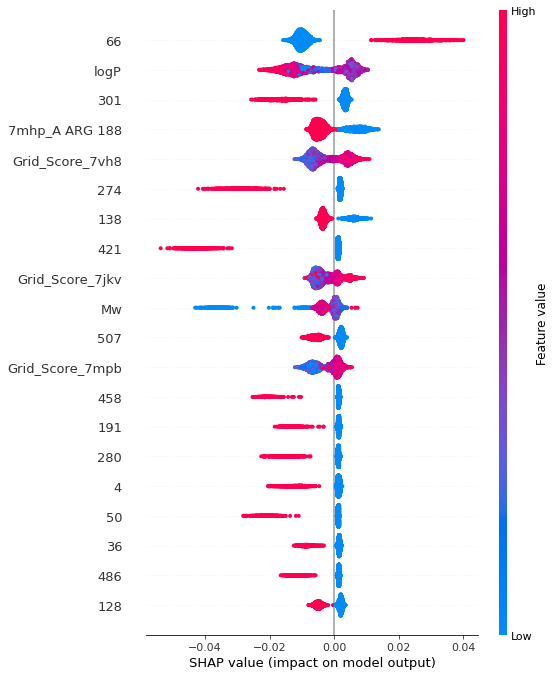

In [ ]:
shap.summary_plot(shap_values4[1], X_train_clean_4)

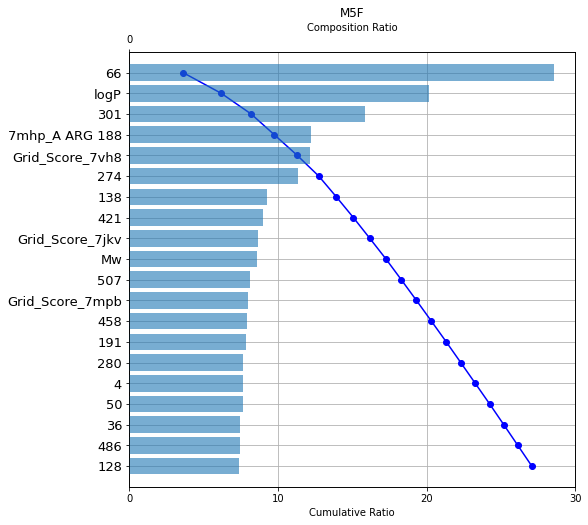

In [ ]:
make_shap_waterfall_plot(shap_values4[1], X_train_clean_4, title = 'M5F')

### Set5

In [ ]:
dataset = Set5
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_5 = X_train_5.drop('Chembl_Name', axis=1)
X_val_clean_5 = X_val_5.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set5.fit(X_train_clean_5,y_train_5)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=5, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer5 = shap.TreeExplainer(RF_model_Set5)
shap_values5 = explainer5.shap_values(X_train_clean_5, approximate=False, check_additivity=False)

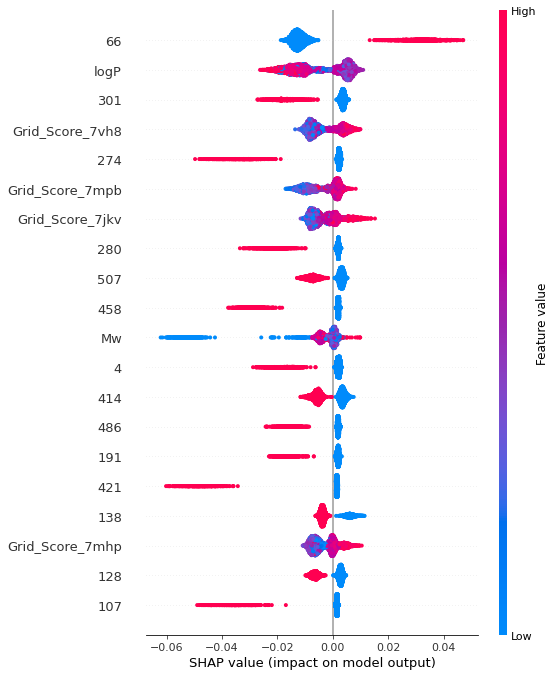

In [ ]:
shap.summary_plot(shap_values5[1], X_train_clean_5)

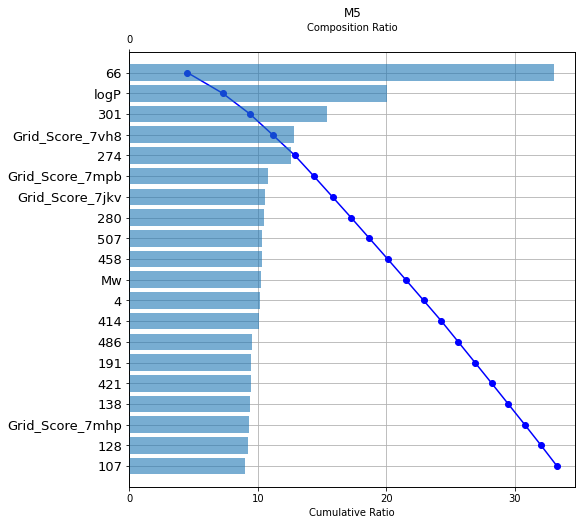

In [ ]:
make_shap_waterfall_plot(shap_values5[1], X_train_clean_5, title='M5')

### Set6

In [ ]:
dataset = Set6
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_6, X_val_6, X_test_6, y_train_6, y_val_6, y_test_6 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_6 = X_train_6.drop('Chembl_Name', axis=1)
X_val_clean_6 = X_val_6.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set6.fit(X_train_clean_6,y_train_6)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer6 = shap.TreeExplainer(RF_model_Set6)
shap_values6 = explainer6.shap_values(X_train_clean_6, approximate=False, check_additivity=False)

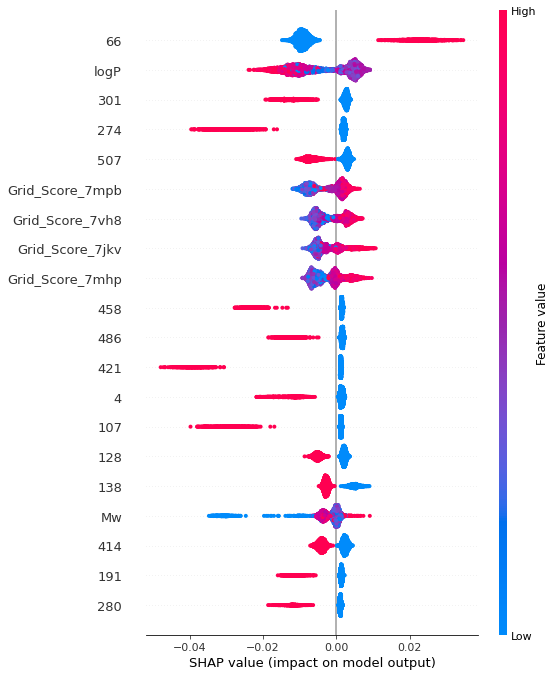

In [ ]:
shap.summary_plot(shap_values6[1], X_train_clean_6)

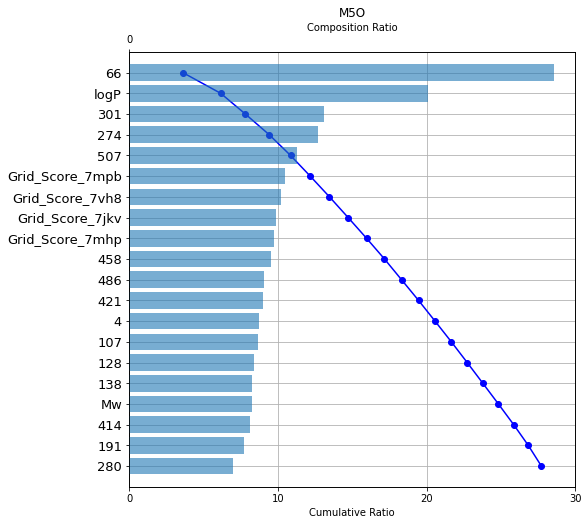

In [ ]:
make_shap_waterfall_plot(shap_values6[1], X_train_clean_6, title='M5O')

### Set7

In [ ]:
dataset = Set7
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_7, X_val_7, X_test_7, y_train_7, y_val_7, y_test_7 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_7 = X_train_7.drop('Chembl_Name', axis=1)
X_val_clean_7 = X_val_7.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set7.fit(X_train_clean_7,y_train_7)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=5, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer7 = shap.TreeExplainer(RF_model_Set7)
shap_values7 = explainer7.shap_values(X_train_clean_7, approximate=False, check_additivity=False)

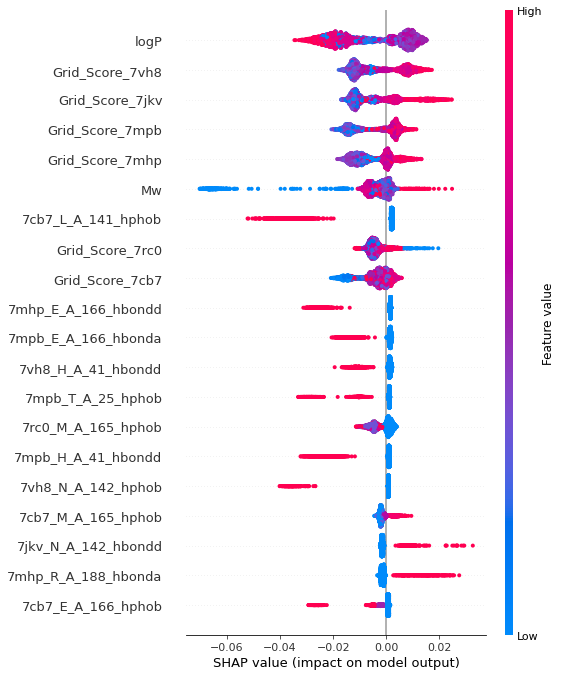

In [ ]:
shap.summary_plot(shap_values7[1], X_train_clean_7)

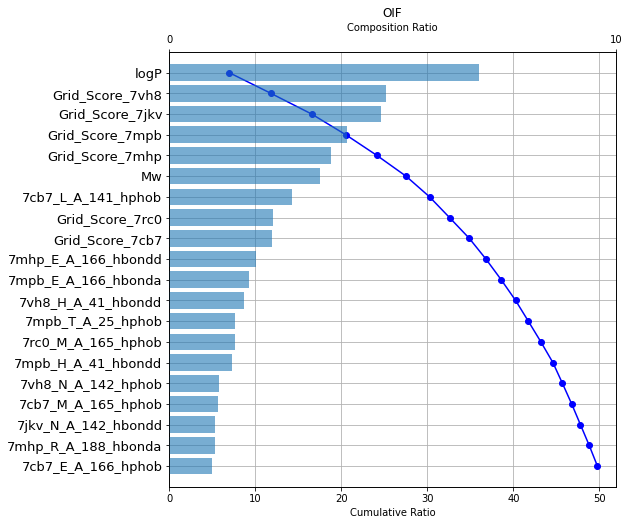

In [ ]:
make_shap_waterfall_plot(shap_values7[1], X_train_clean_7, title='OIF')

### Set8

In [ ]:
dataset = Set8
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_8, X_val_8, X_test_8, y_train_8, y_val_8, y_test_8 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_8 = X_train_8.drop('Chembl_Name', axis=1)
X_val_clean_8 = X_val_8.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set8.fit(X_train_clean_8,y_train_8)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer8 = shap.TreeExplainer(RF_model_Set8)
shap_values8 = explainer8.shap_values(X_train_clean_8, approximate=False, check_additivity=False)

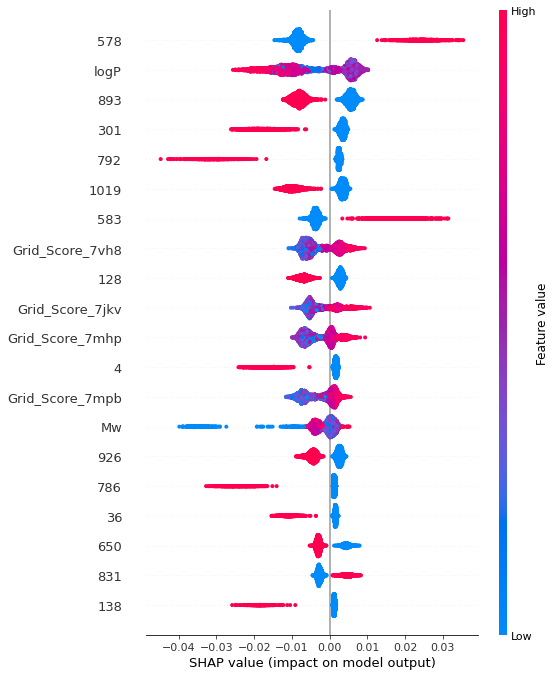

In [ ]:
shap.summary_plot(shap_values8[1], X_train_clean_8)

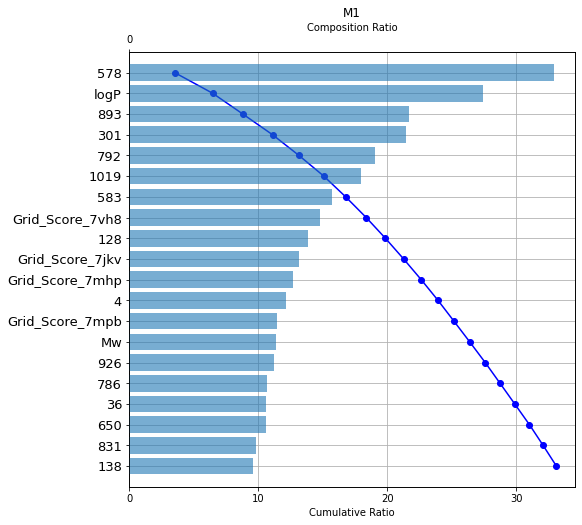

In [ ]:
make_shap_waterfall_plot(shap_values8[1], X_train_clean_8, title='M1')

### Set9

In [ ]:
dataset = Set9
y = dataset['Experiment_label']
X = dataset.drop(['Experiment_label', 'Experiment_rank', 'Percent'], axis = 1)
X_train_9, X_val_9, X_test_9, y_train_9, y_val_9, y_test_9 = train_test_val_prep(X, y, test_size = 0.3, random_state = 42)
X_train_clean_9 = X_train_9.drop('Chembl_Name', axis=1)
X_val_clean_9 = X_val_9.drop('Chembl_Name', axis=1)

In [ ]:
RF_model_Set9.fit(X_train_clean_9,y_train_9)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=1000, random_state=42)

In [ ]:
explainer9 = shap.TreeExplainer(RF_model_Set9)
shap_values9 = explainer9.shap_values(X_train_clean_9, approximate=False, check_additivity=False)

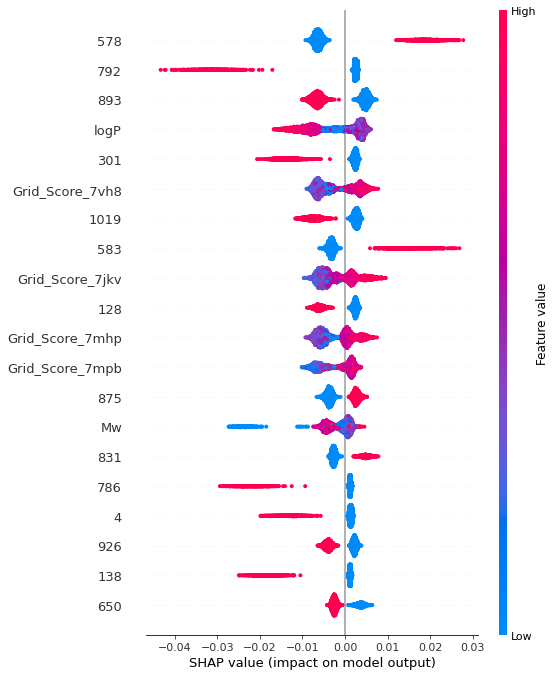

In [ ]:
shap.summary_plot(shap_values9[1], X_train_clean_9)

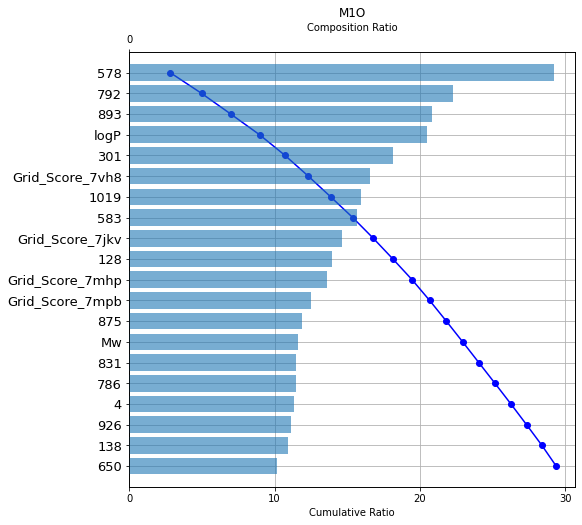

In [ ]:
make_shap_waterfall_plot(shap_values9[1], X_train_clean_9, title='M1O')